In [1]:
# Adjust the working directly to import packages using the root package
import sys
import os
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pymc as pm
import pytensor as pt
import seaborn as sns
from estimation.mixnorm.ksigma.model import tempered_normal_mixture

In [3]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.23.0


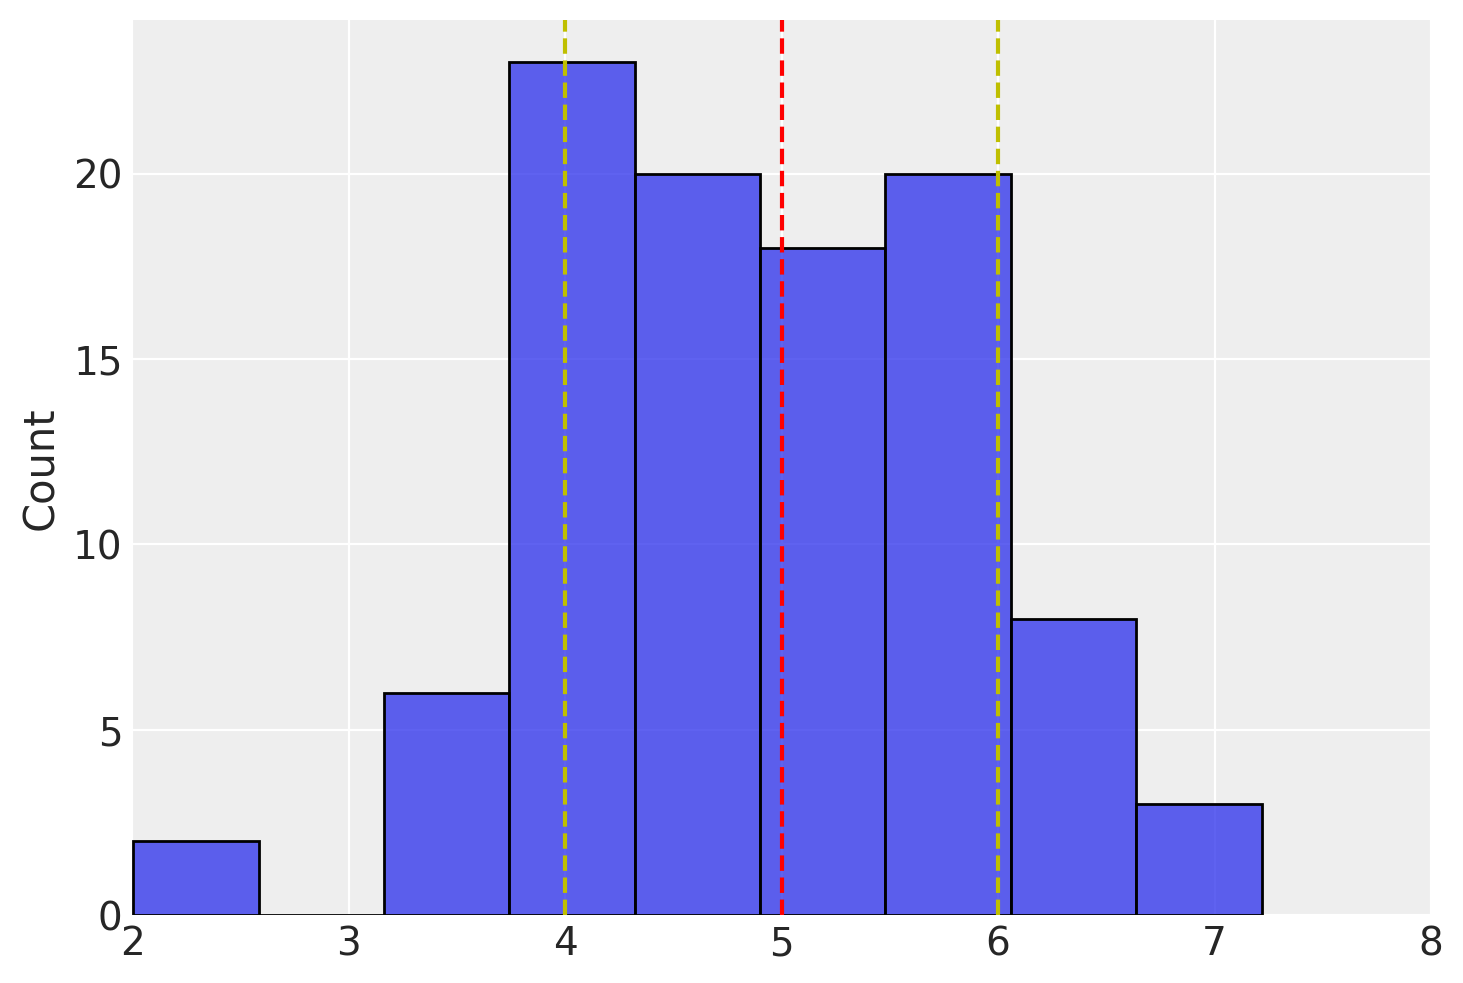

In [6]:
# True parameter values
n=100
mu=5
sigma=1
# sample sizes for the different simulations
x_data = np.random.normal(loc=mu, scale=sigma**2, size=n)
sns.histplot(x_data)
plt.xlim(mu-3*np.sqrt(sigma), mu+3*np.sqrt(sigma))
plt.axvline(x=mu, color='r', linestyle='--', label='mean')
plt.axvline(x=mu-np.sqrt(sigma), color='y', linestyle='--', label='SD low')
plt.axvline(x=mu+np.sqrt(sigma), color='y', linestyle='--', label='SD high')
plt.show()

In [30]:
model = tempered_normal_mixture(beta=1/np.log(len(x_data)), 
                                data=x_data, 
                                n_components=3,
                                weights_prior_alpha=np.full(3, 0.1),
                                mean_prior_mu=pt.tensor.ones(3)*10,
                                mean_prior_cov=pt.tensor.eye(3)*100
                               )

with model:
    idata = pm.sample(draws=6000, tune=4000, chains=4,
                      cores=4, max_treedepth=50, target_accept=.995)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mus, like]


Output()

Sampling 4 chains for 4_000 tune and 6_000 draw iterations (16_000 + 24_000 draws total) took 258 seconds.


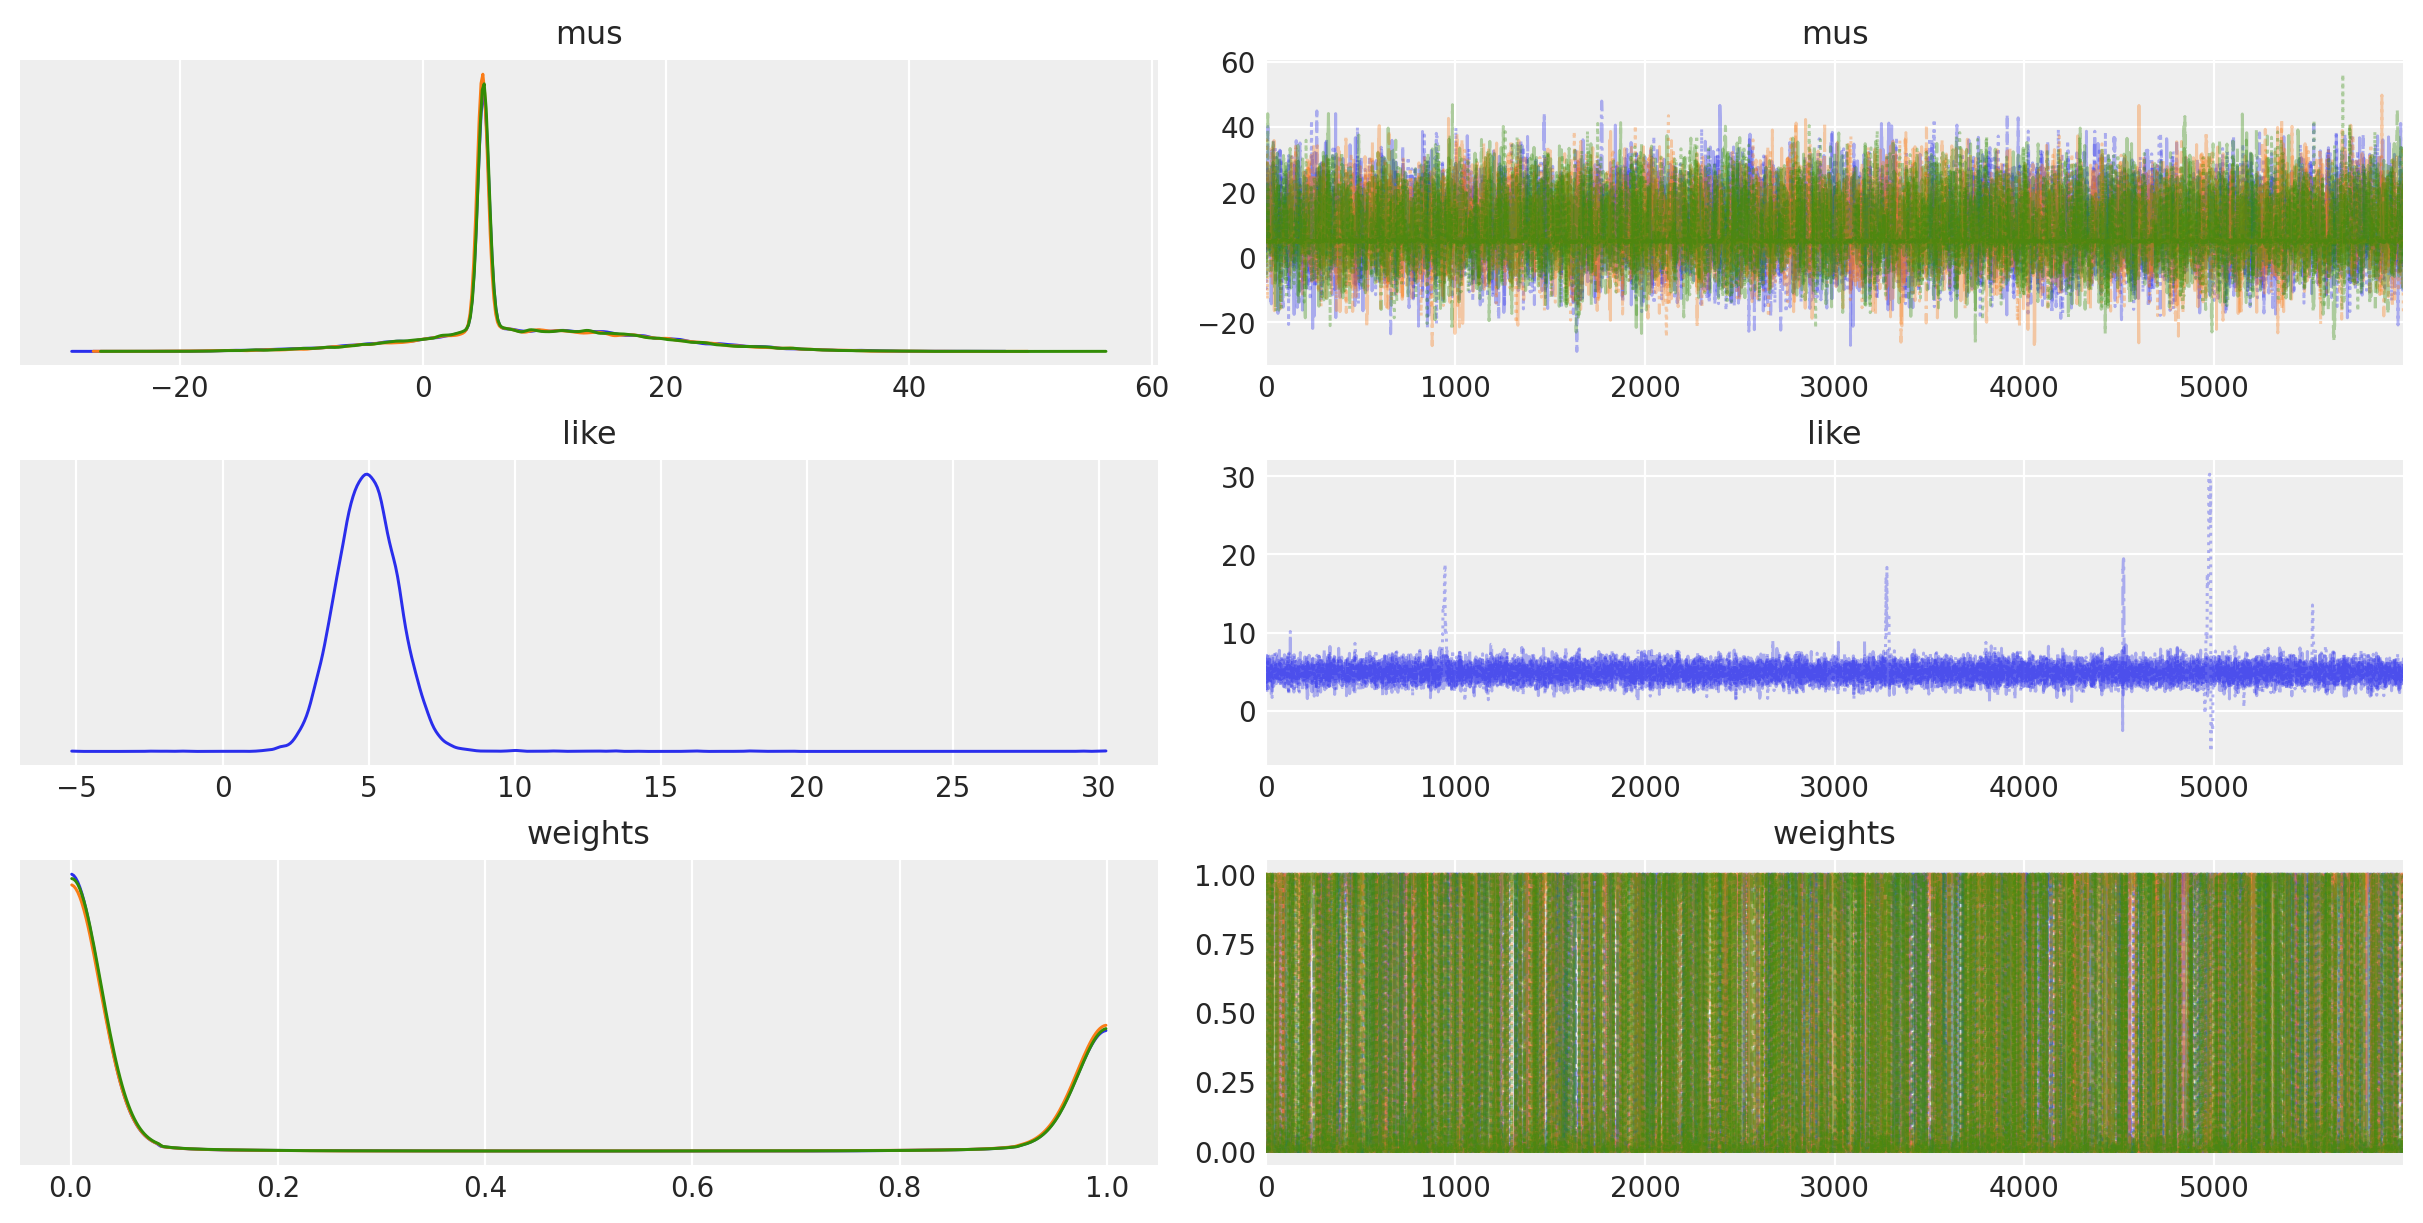

In [31]:
az.plot_trace(idata, combined=True);

array([[<Axes: ylabel='weights\n1'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='weights\n2'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='mus\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='mus\n1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='weights\n0', ylabel='mus\n2'>,
        <Axes: xlabel='weights\n1'>, <Axes: xlabel='weights\n2'>,
        <Axes: xlabel='mus\n0'>, <Axes: xlabel='mus\n1'>]], dtype=object)

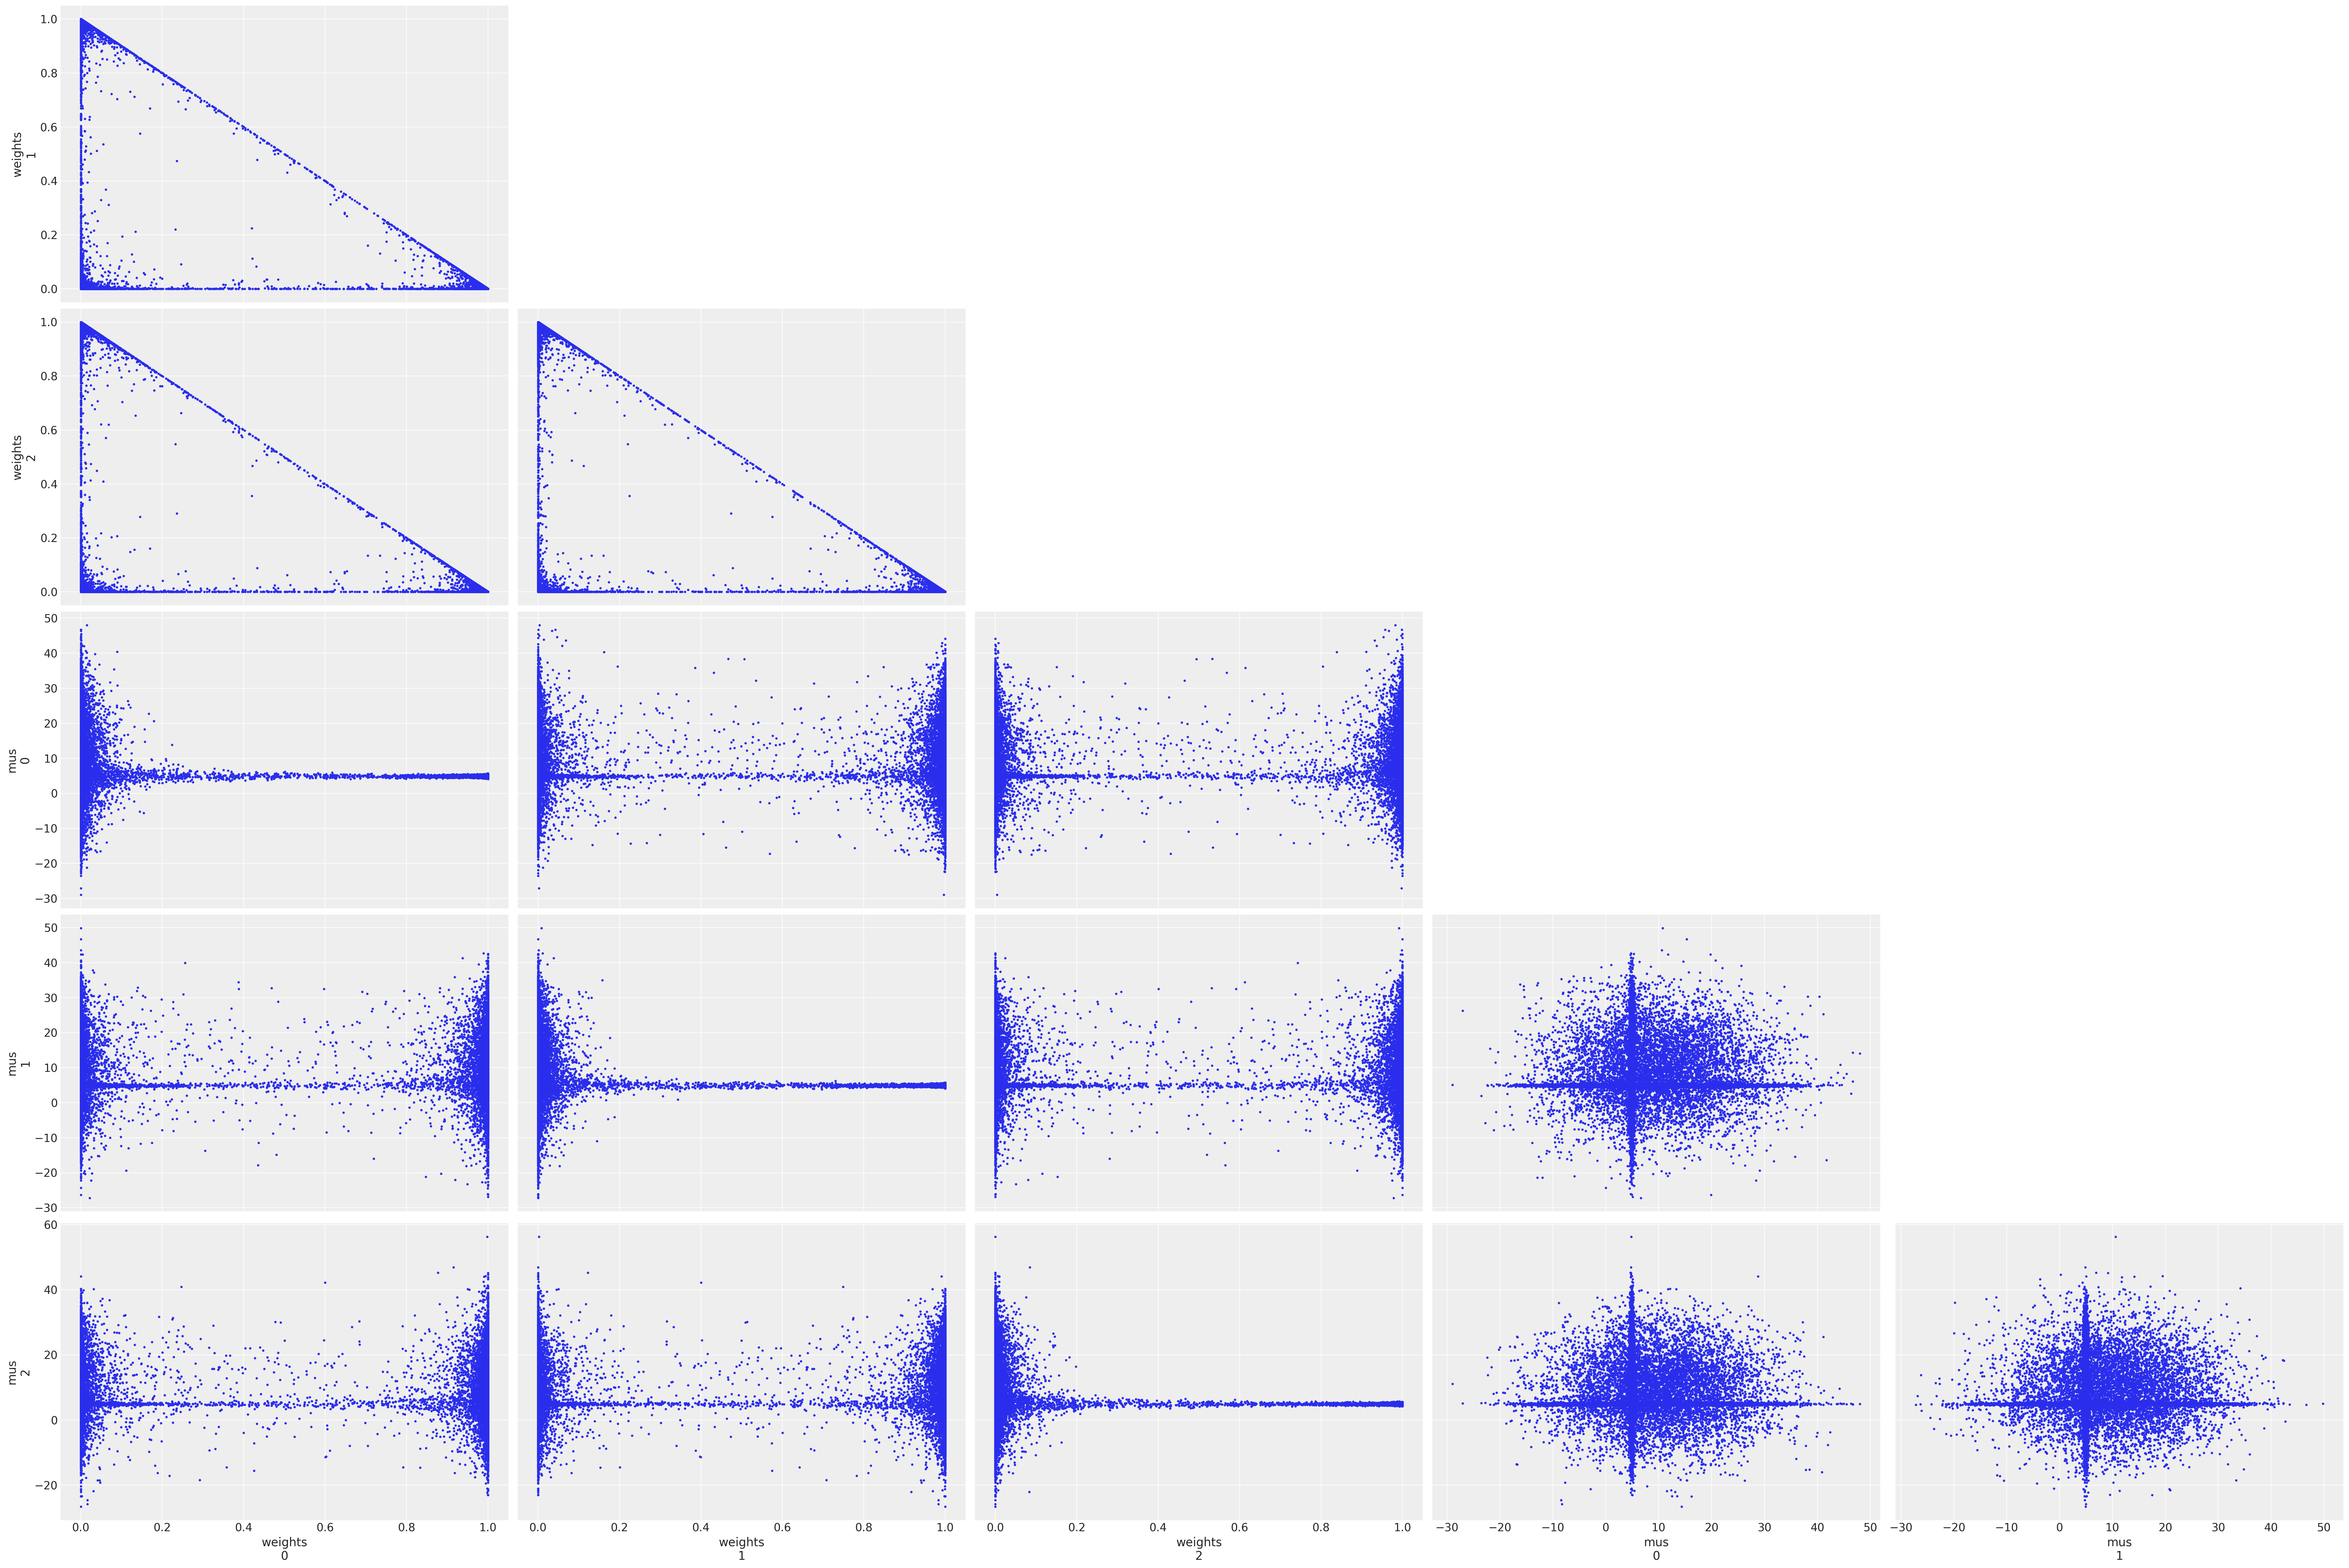

In [32]:
az.plot_pair(idata, var_names=["weights", "mus"], kind="scatter")

array([[<Axes: title={'center': 'weights\n0'}>,
        <Axes: title={'center': 'weights\n1'}>,
        <Axes: title={'center': 'weights\n2'}>],
       [<Axes: title={'center': 'mus\n0'}>,
        <Axes: title={'center': 'mus\n1'}>,
        <Axes: title={'center': 'mus\n2'}>]], dtype=object)

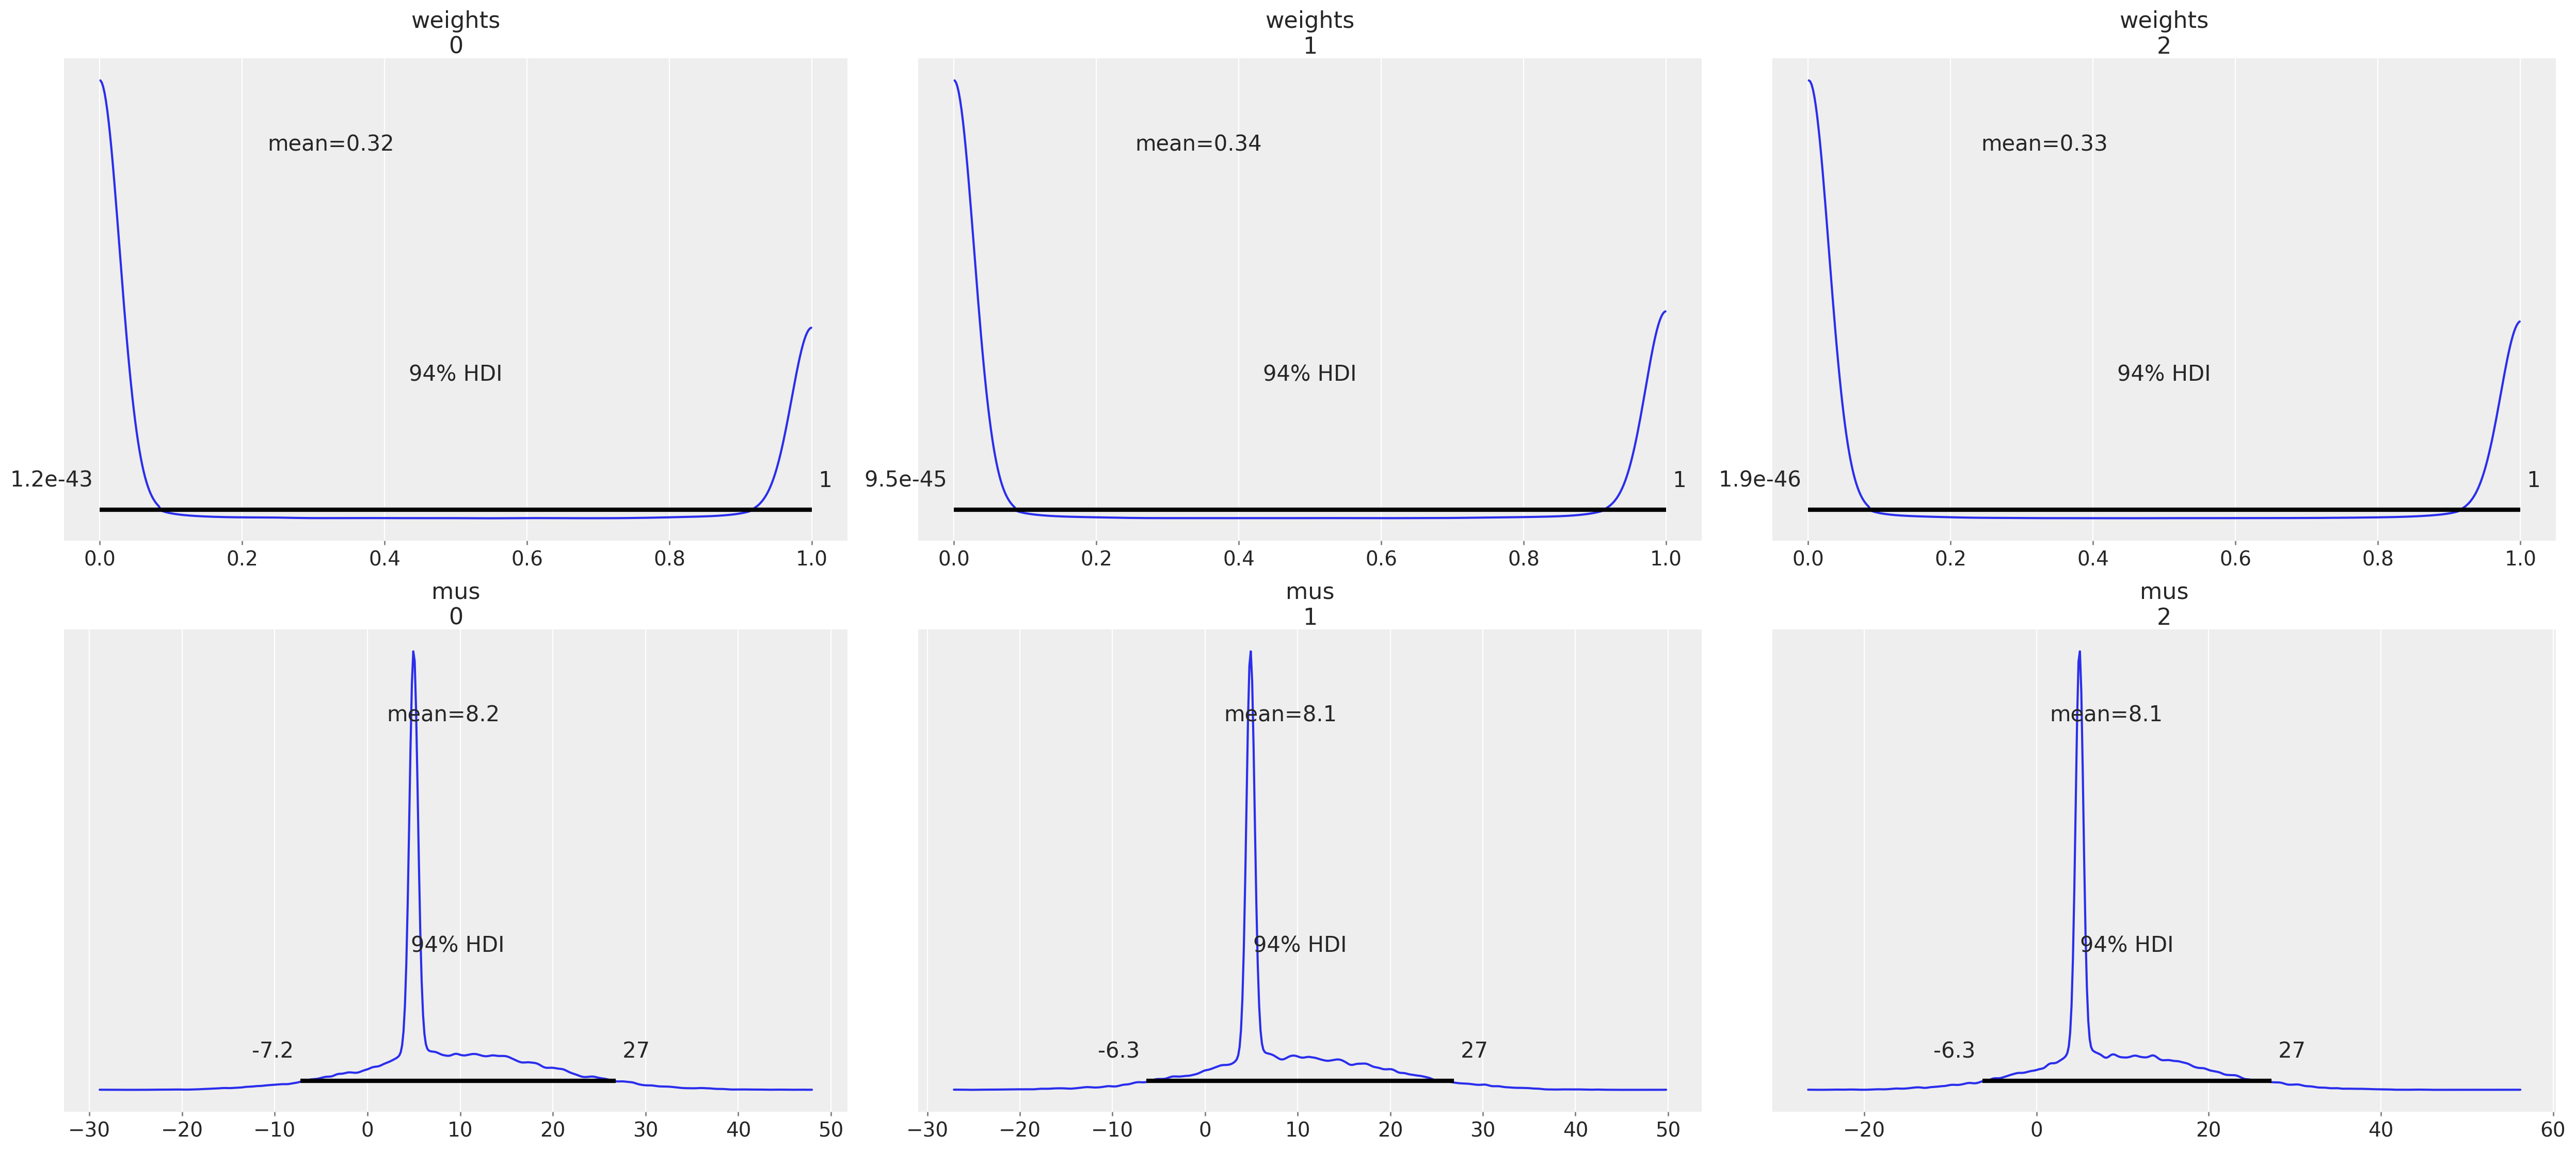

In [33]:
az.plot_posterior(idata, var_names=["weights", "mus"])

In [17]:
az.summary(idata, var_names=["weights", "mus"], round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
weights[0]  0.33  0.46    0.00     1.00       0.01     0.00   2056.32   
weights[1]  0.33  0.46    0.00     1.00       0.01     0.00   2172.64   
weights[2]  0.33  0.46    0.00     1.00       0.01     0.00   2015.31   
mus[0]      4.35  7.85  -12.48    20.51       0.08     0.12   8970.91   
mus[1]      4.31  8.01  -13.35    20.16       0.09     0.12   8419.39   
mus[2]      4.40  7.92  -12.75    20.30       0.09     0.11   7769.86   

            ess_tail  r_hat  
weights[0]   5937.80    1.0  
weights[1]   6808.26    1.0  
weights[2]   6188.55    1.0  
mus[0]       8273.73    1.0  
mus[1]       8497.01    1.0  
mus[2]       8722.08    1.0

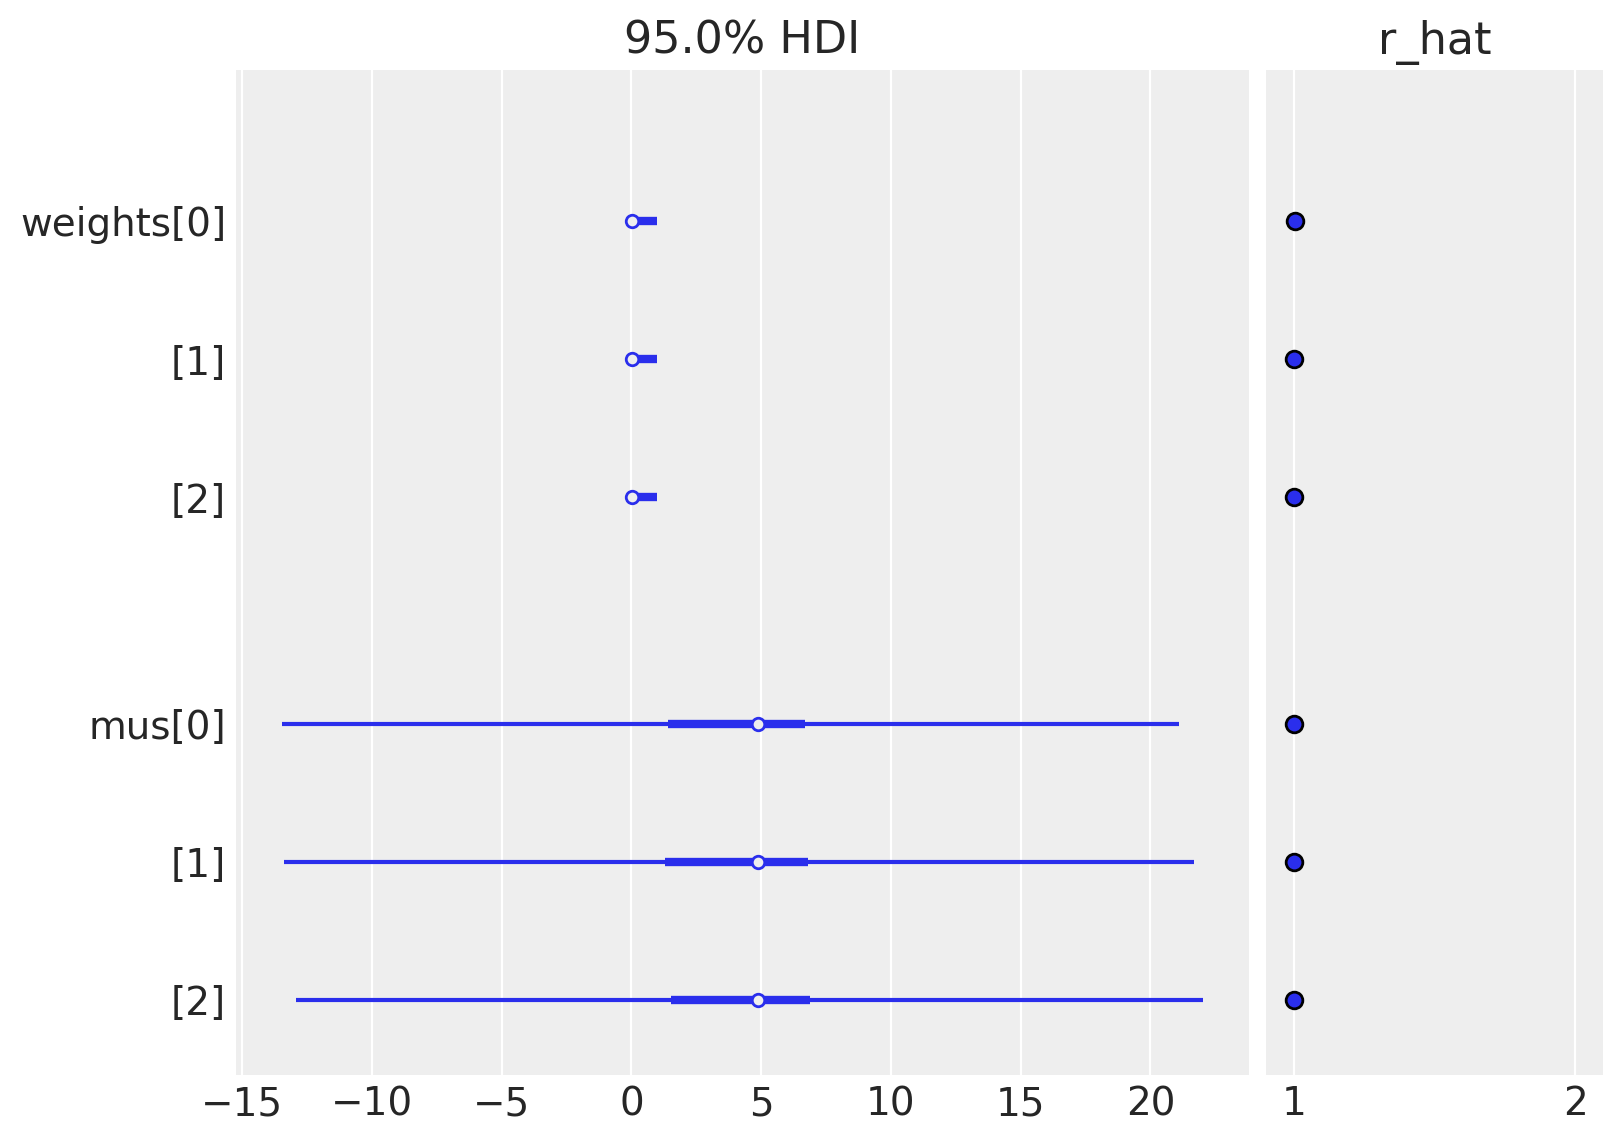

In [18]:
az.plot_forest(idata, var_names=["weights", "mus"], combined=True, hdi_prob=0.95, r_hat=True);

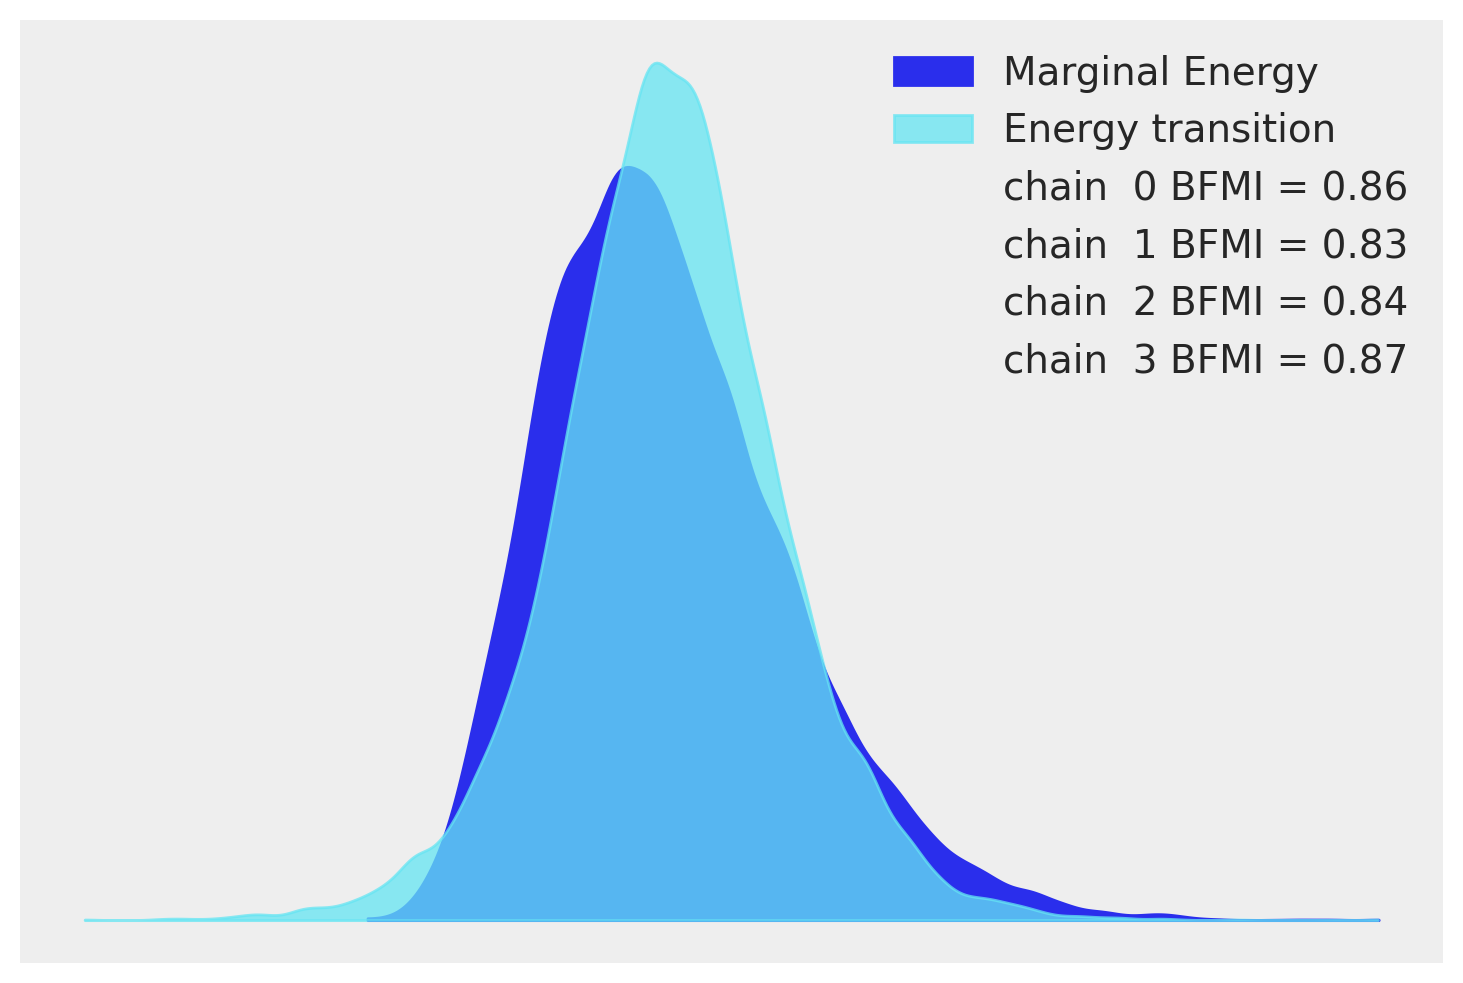

In [19]:
az.plot_energy(idata);

In [20]:
def view3d(x, y, z, ax):
    colors = ['red', 'blue', 'green', 'yellow']
    
    # --- 4. Loop through chains and plot ---
    for i in range(4):
        x_dim = x.split(".")
        y_dim = y.split(".")
        z_dim = z.split(".")
        print(x_dim)
        x_coords = idata.posterior[x_dim[0]][i, :, :][:, int(x_dim[1])]
        y_coords = idata.posterior[y_dim[0]][i, :, :][:, int(y_dim[1])]
        z_coords = idata.posterior[z_dim[0]][i, :, :][:, int(z_dim[1])]
    
        ax.scatter(
            x_coords,
            y_coords,
            z_coords,
            c=colors[i % len(colors)], # Use modulo to cycle colors if more chains than colors
            s=5,                     # Size of markers
            alpha=0.7,                # Transparency
            # edgecolor='k',            # Black edges for markers
            label=f'Chain {i}'        # Label for the legend
        )
    
    # Adjust viewing angle (optional)
    ax.set_xlabel(f"{x_dim[0]}[{x_dim[1]}]")
    ax.set_ylabel(f"{y_dim[0]}[{y_dim[1]}]")
    ax.set_zlabel(f"{z_dim[0]}[{z_dim[1]}]")
    ax.view_init(elev=45, azim=45)

['mus', '0']
['mus', '0']
['mus', '0']
['mus', '0']


/var/folders/jf/4t6y1sj967l2ctl46wj73srh0000gn/T/ipykernel_53680/2086425152.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


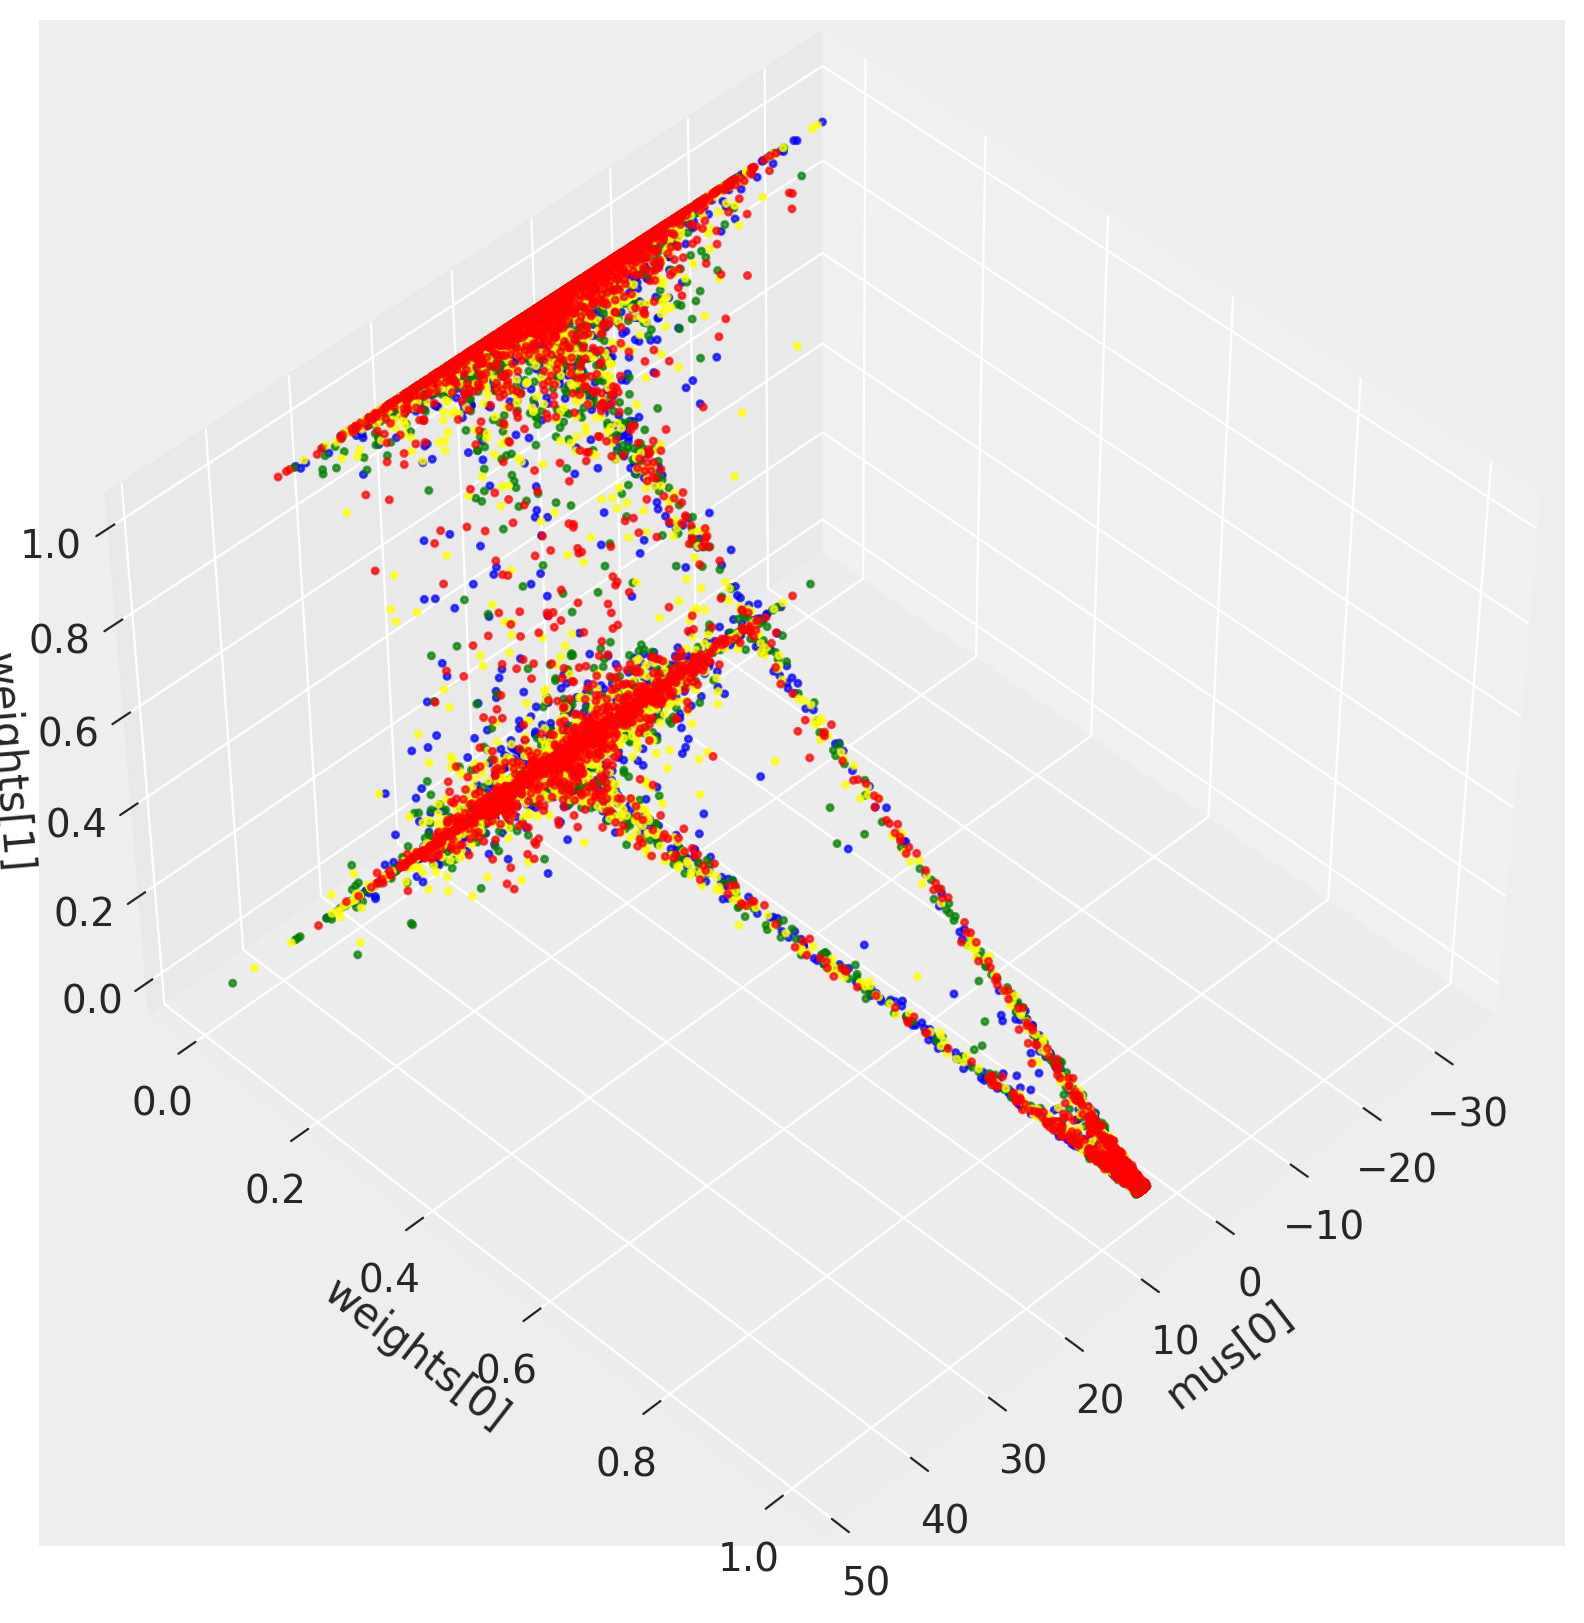

In [21]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
view3d(x="mus.0", y="weights.0", z="weights.1", ax=ax)

# Tight layout ensures labels and titles fit
# fig.tight_layout()
fig.show()
fig.savefig('symmetry_w1_w2_mu1.png', dpi=300, bbox_inches='tight')

In [ ]:
plt.hist(idata.posterior["weights"][3,:,:])